In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 

In [2]:
!pip install --upgrade setuptools pip --user
!pip install --ignore-installed PyYAML
!pip install Pillow

!pip install nvidia-pyindex
!pip install --upgrade nvidia-tensorrt
!pip install pycuda

!pip install protobuf<4.21.3
!pip install onnxruntime-gpu
!pip install onnx>=1.9.0
!pip install onnx-simplifier>=0.3.6 --user

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 kB 8.4 MB/s eta 0:00:00a 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
/bin/bash: line 1: 4.21.3: No such file or directory
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import sys
import torch
print(f"Python version: {sys.version}, {sys.version_info} ")
print(f"Pytorch version: {torch.__version__} ")

Python version: 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:18) 
[GCC 10.3.0], sys.version_info(major=3, minor=8, micro=13, releaselevel='final', serial=0) 
Pytorch version: 1.12.1 


In [4]:
!nvidia-smi

Wed Sep 21 18:16:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 55%   54C    P2   170W / 350W |  21669MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:0A:00.0 Off |                  N/A |
| 30%   

In [5]:
# !# Download YOLOv7 code
# !git clone https://github.com/WongKinYiu/yolov7
%cd ..
!ls

/home/xin/OneDrive/xin/yolov7
best.pt        export.py   paper	     scripts	      utils
cfg	       figure	   pretrained	     test.py	      wandb
customization  hubconf.py  __pycache__	     tools
data	       inference   README.md	     traced_model.pt
deploy	       LICENSE.md  requirements.txt  train_aux.py
detect.py      models	   runs		     train.py


In [6]:
# !# Download trained weights
# !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

In [7]:
# !python detect.py --weights ./yolov7-tiny.pt --conf 0.25 --img-size 640 --source inference/images/horses.jpg

In [8]:
# from PIL import Image
# Image.open('/content/yolov7/runs/detect/exp/horses.jpg')

In [9]:
# export temporary ONNX model for TensorRT converter
!python export.py --weights ./pretrained/yolov7.pt --grid --end2end --simplify --topk-all 100 --iou-thres 0.65 --conf-thres 0.35 --img-size 640 640
!ls

Namespace(batch_size=1, conf_thres=0.35, device='cpu', dynamic=False, dynamic_batch=False, end2end=True, fp16=False, grid=True, img_size=[640, 640], include_nms=False, int8=False, iou_thres=0.65, max_wh=None, simplify=True, topk_all=100, weights='./pretrained/yolov7.pt')
YOLOR 🚀 8e8e228 torch 1.12.1 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
Model Summary: 306 layers, 36905341 parameters, 36905341 gradients
/home/xin/anaconda3/envs/yolov7/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484683044/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

Starting TorchScript export with torch 1.12.1...
/home/xin/OneDrive/xin/yolov7/models/yolo.py:52: TracerWarning: Converting a tensor to a Python boolean

In [10]:
# Download ONNX to TensorRT converter
%cd ../
# !git clone https://github.com/Linaom1214/tensorrt-python.git

/home/xin/OneDrive/xin


In [11]:
%cd tensorrt-python
!ls

/home/xin/OneDrive/xin/tensorrt-python
cpp		image_batch.py	README.md  utils
Examples.ipynb	__pycache__	src	   yolov7-custom-nms.trt
export.py	README_CN.md	trt.py	   yolov7-tiny-custom-nms.trt


In [12]:
# Export TensorRT-engine model 
!python export.py -o ../yolov7/pretrained/yolov7.onnx -e ./yolov7-nms.trt -p fp16

Namespace(calib_batch_size=8, calib_cache='./calibration.cache', calib_input=None, calib_num_images=5000, conf_thres=0.4, end2end=False, engine='./yolov7-nms.trt', iou_thres=0.5, max_det=100, onnx='../yolov7/pretrained/yolov7.onnx', precision='fp16', verbose=False, workspace=1)
[09/21/2022-18:16:31] [TRT] [I] [MemUsageChange] Init CUDA: CPU +320, GPU +0, now: CPU 343, GPU 443 (MiB)
[09/21/2022-18:16:31] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +327, GPU +104, now: CPU 689, GPU 547 (MiB)
export.py:109: DeprecationWarning: Use set_memory_pool_limit instead.
  self.config.max_workspace_size = workspace * (2 ** 30)
[09/21/2022-18:16:32] [TRT] [W] onnx2trt_utils.cpp:369: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[09/21/2022-18:16:32] [TRT] [W] onnx2trt_utils.cpp:395: One or more weights outside the range of INT32 was clamped
[09/21/2022-18:16:32] [TRT] [I] No importer registered

In [13]:
import cv2
import torch
import random
import time
import numpy as np
import tensorrt as trt
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

In [16]:
w = './yolov7-nms.trt'
device = torch.device('cuda:0')
img = cv2.imread('../yolov7/inference/images/horses.jpg')

In [17]:
# Infer TensorRT Engine
Binding = namedtuple('Binding', ('name', 'dtype', 'shape', 'data', 'ptr'))
logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, namespace="")
with open(w, 'rb') as f, trt.Runtime(logger) as runtime:
    model = runtime.deserialize_cuda_engine(f.read())
bindings = OrderedDict()
for index in range(model.num_bindings):
    name = model.get_binding_name(index)
    dtype = trt.nptype(model.get_binding_dtype(index))
    shape = tuple(model.get_binding_shape(index))
    data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
    bindings[name] = Binding(name, dtype, shape, data, int(data.data_ptr()))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
context = model.create_execution_context()


def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

def postprocess(boxes,r,dwdh):
    dwdh = torch.tensor(dwdh*2).to(boxes.device)
    boxes -= dwdh
    boxes /= r
    return boxes

names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

[09/21/2022-18:32:14] [TRT] [I] [MemUsageChange] Init CUDA: CPU +329, GPU +0, now: CPU 402, GPU 443 (MiB)
[09/21/2022-18:32:14] [TRT] [I] Loaded engine size: 73 MiB
[09/21/2022-18:32:15] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +809, GPU +348, now: CPU 1315, GPU 865 (MiB)
[09/21/2022-18:32:15] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +126, GPU +60, now: CPU 1441, GPU 925 (MiB)
[09/21/2022-18:32:15] [TRT] [W] TensorRT was linked against cuDNN 8.4.1 but loaded cuDNN 8.3.2
[09/21/2022-18:32:15] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +0, now: CPU 0, GPU 0 (MiB)
[09/21/2022-18:32:16] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 2194, GPU 1299 (MiB)
[09/21/2022-18:32:16] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 2194, GPU 1307 (MiB)
[09/21/2022-18:32:16] [TRT] [W] TensorRT was linked against cuDNN 8.4.1 but loaded cuDNN 8.3.2
[09/21/2022-18:32:16] [TRT] [I] [MemUsageChange]

In [18]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im.shape

(1, 3, 640, 640)

Cost 0.002675267867743969 s


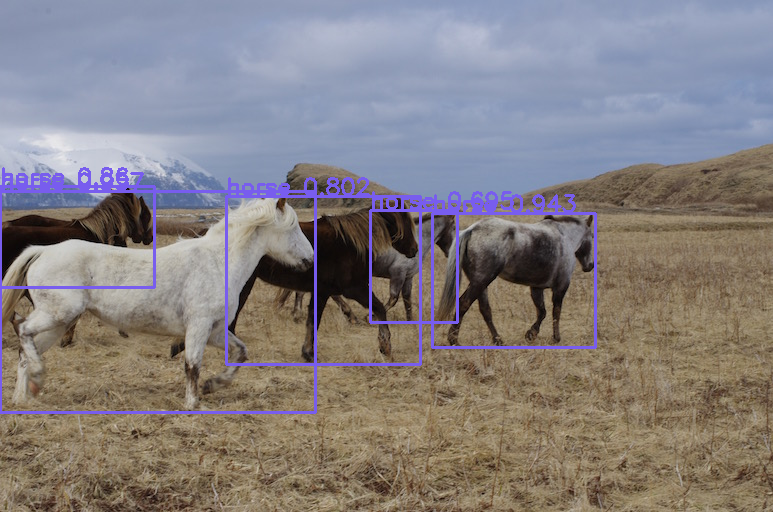

In [19]:
im = torch.from_numpy(im).to(device)
im/=255
im.shape

# warmup for 10 times
for _ in range(10):
    tmp = torch.randn(1,3,640,640).to(device)
    binding_addrs['images'] = int(tmp.data_ptr())
    context.execute_v2(list(binding_addrs.values()))

start = time.perf_counter()
binding_addrs['images'] = int(im.data_ptr())
context.execute_v2(list(binding_addrs.values()))
print(f'Cost {time.perf_counter()-start} s')

nums = bindings['num_dets'].data
boxes = bindings['det_boxes'].data
scores = bindings['det_scores'].data
classes = bindings['det_classes'].data
nums.shape,boxes.shape,scores.shape,classes.shape

boxes = boxes[0,:nums[0][0]]
scores = scores[0,:nums[0][0]]
classes = classes[0,:nums[0][0]]

for box,score,cl in zip(boxes,scores,classes):
    box = postprocess(box,ratio,dwdh).round().int()
    name = names[cl]
    color = colors[name]
    name += ' ' + str(round(float(score),3))
    cv2.rectangle(img,box[:2].tolist(),box[2:].tolist(),color,2)
    cv2.putText(img,name,(int(box[0]), int(box[1]) - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,color,thickness=2)

Image.fromarray(img)